# Introduction to using ParticleSpy

This is an example notebook for performing particle analysis using ParticleSpy.

This notebook takes a HAADF image of nanoparticles, allows the user to determine the best segmentation method and then performs analysis, producing a plot of particle areas.

Below, we load an image using Hyperspy.

C:\Users\Tom Slater\anaconda3\envs\particlespy_270423\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
C:\Users\Tom Slater\anaconda3\envs\particlespy_270423\lib\site-packages\hyperspy\misc\utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(
C:\Users\Tom Slater\anaconda3\envs\particlespy_270423\lib\site-packages\hyperspy\io.py:572: VisibleDeprecationWarning: Loading old file version. The binned attribute has been moved from metadata.Signal to axis.is_binned. Setting this attribute for all signal axes instead.
  warnings.warn('Loading old file version. The binned attribute '


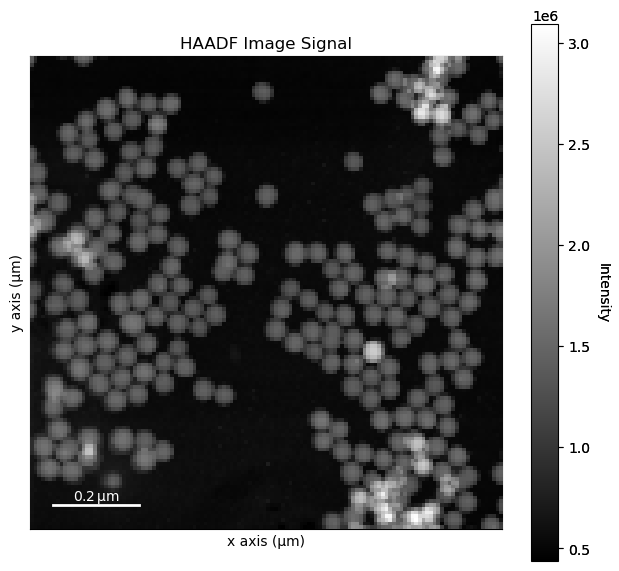

In [1]:
import hyperspy.api as hs
import particlespy.api as ps
import trackpy as tp
import matplotlib.pyplot as plt

filename = 'SiO2 HAADF Image.hspy'
haadf = hs.load(filename)

%matplotlib inline
haadf.plot()

ParticleSpy works by defining parameters to run segmentation. This is done through the parameters object, which can be loaded with default values.

In [2]:
params = ps.parameters()
params.generate()

Let's take a look at the default segmentation parameters.

In [3]:
params.segment

{'threshold': 'otsu',
 'watershed': False,
 'watershed_size': 0,
 'watershed_erosion': 0,
 'invert': False,
 'min_size': 0,
 'rb_kernel': 0,
 'gaussian': 0,
 'local_size': 1}

The default is a simple Otsu threshold with no other options selected. We could apply these parameters to segment the particles but we don't know how well these will work on our individual images. In order to check this out, we can use ParticleSpy's segmentation GUI. Experiment with changing the threshold algorithm and the application of watershedding to obtain the optimum labels. Once happy, click "Get Params" to print the current parameters.

<span style="color:red">WARNING: Don't run this if on Google Cloud Platform!</span>

In [4]:
ps.seg_ui(haadf)

{'threshold': 'otsu', 'watershed': True, 'watershed_size': 5, 'watershed_erosion': 0, 'invert': False, 'min_size': 0, 'rb_kernel': 0, 'gaussian': 0, 'local_size': 1}


Next, we use the parameters saved when last pressing Update in the GUI to construct a parameter dictionary.

In [6]:
params.load()
params.store['store_im'] = True

In [7]:
params.segment

{'threshold': 'otsu',
 'watershed': True,
 'watershed_size': 5,
 'watershed_erosion': 0,
 'invert': False,
 'min_size': 0,
 'rb_kernel': 0,
 'gaussian': 0,
 'local_size': 1}

If running a notebook on a remote server there is an alternative method to check segmentation parameters using the process function (however, this isn't included in the api).

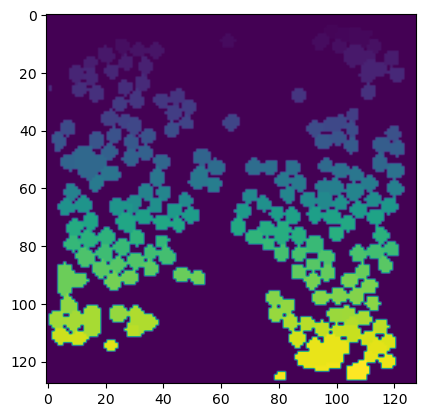

In [8]:
import particlespy
seg = particlespy.segptcls.process(haadf,params)
plt.figure()
plt.imshow(seg)

Once we're happy with the segmentation parameters, we run the particle_analysis function to segment our image and provide a list of all the particles.

In [9]:
particles = ps.particle_analysis(haadf,params)

c:\users\tom slater\onedrive - cardiff university\documents\github\particlespy\particlespy\particle_analysis.py:111: RuntimeWarning: divide by zero encountered in double_scalars
  circularity = 4*3.14159265*p.properties['area']['value']/(peri**2)


Let's interrogate the particle data a little bit. From an initial image we get a number of particle properties calculated automatically.

In [10]:
particles.list

In [11]:
print(particles.list[0].properties)

{'area': {'value': 0.0013897423288512954, 'units': 'µm^2'}, 'equivalent circular diameter': {'value': 0.042065126768925924, 'units': 'µm'}, 'x': {'value': 0.04861390374993023, 'units': 'µm'}, 'y': {'value': 0.839490097163147, 'units': 'µm'}, 'major axis length': {'value': 0.04343684018581211, 'units': 'µm'}, 'minor axis length': {'value': 0.04152910281239791, 'units': 'µm'}, 'circularity': {'value': 1.2801536991122482, 'units': None}, 'eccentricity': {'value': 0.2931051908802741, 'units': None}, 'solidity': {'value': 0.95, 'units': None}, 'intensity': {'value': 9467681.0, 'units': None}, 'intensity_max': {'value': 738979.7, 'units': None}, 'intensity_std': {'value': 0.023866808, 'units': None}, 'bbox_area': {'value': 0.001828608327435915, 'units': 'µm^2'}, 'bbox_length': {'value': 0.06047492583601761, 'units': 'µm'}, 'frame': {'value': None, 'units': None}}


It is then possible to plot a histogram of particle area.

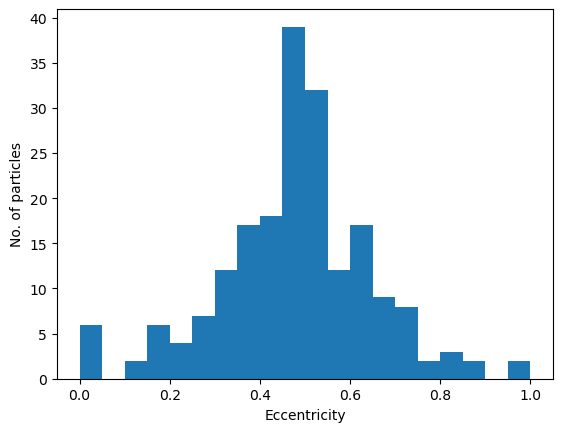

In [14]:
particles.plot('eccentricity',bins=20)

It is also possible to plot a scatter plot of two properties. In this instance, plotting 'intensity' vs area.

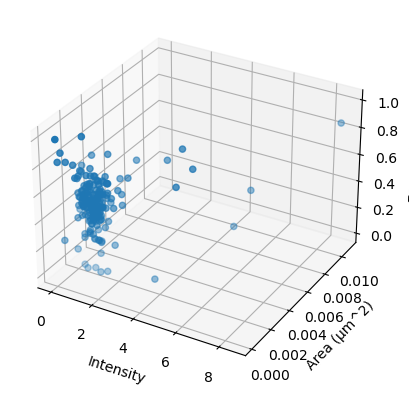

In [16]:
particles.plot(['intensity','area','eccentricity'])

## ParticleSpy with EDS data

If you have EDS data collected simultaneously with an image, it is possible to extract maps, spectra and the composition from each segmented particle. Firstly, load the EDS spectrum image.

In [17]:
eds_filename = 'SiO2 EDS Spectrum Image.hspy'
eds = hs.load(eds_filename)

C:\Users\Tom Slater\anaconda3\envs\particlespy_270423\lib\site-packages\hyperspy\misc\utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(
C:\Users\Tom Slater\anaconda3\envs\particlespy_270423\lib\site-packages\hyperspy\io.py:572: VisibleDeprecationWarning: Loading old file version. The binned attribute has been moved from metadata.Signal to axis.is_binned. Setting this attribute for all signal axes instead.
  warnings.warn('Loading old file version. The binned attribute '


Next, put the HAADF image and EDS spectrum image together in a list to make one acquisition.

In [18]:
ac = [haadf.isig[0:32,0:32],eds.inav[0:32,0:32]]

At this point, we need to set the parameters for the EDS analysis. This can be done by taking our previously used parameters object adding parameters with generate_eds().

In [19]:
params.generate_eds(eds_method='CL',elements=['Si','O'],factors=[1.1,1.3],store_maps=True)

Now, we need to run ParticleAnalysis again in order to get the accompanying EDS data.

In [20]:
particles2 = ps.particle_analysis(ac,params)

[########################################] | 100% Completed | 117.78 ms
[########################################] | 100% Completed | 113.63 ms
[########################################] | 100% Completed | 109.85 ms
[########################################] | 100% Completed | 117.56 ms
[########################################] | 100% Completed | 107.33 ms
[########################################] | 100% Completed | 103.11 ms
[########################################] | 100% Completed | 105.56 ms


c:\users\tom slater\onedrive - cardiff university\documents\github\particlespy\particlespy\particle_analysis.py:111: RuntimeWarning: divide by zero encountered in double_scalars
  circularity = 4*3.14159265*p.properties['area']['value']/(peri**2)


[########################################] | 100% Completed | 104.49 ms
[########################################] | 100% Completed | 109.49 ms
[########################################] | 100% Completed | 116.00 ms
[########################################] | 100% Completed | 108.59 ms


The extracted maps of each element can be accessed from the particle list from maps['element'].

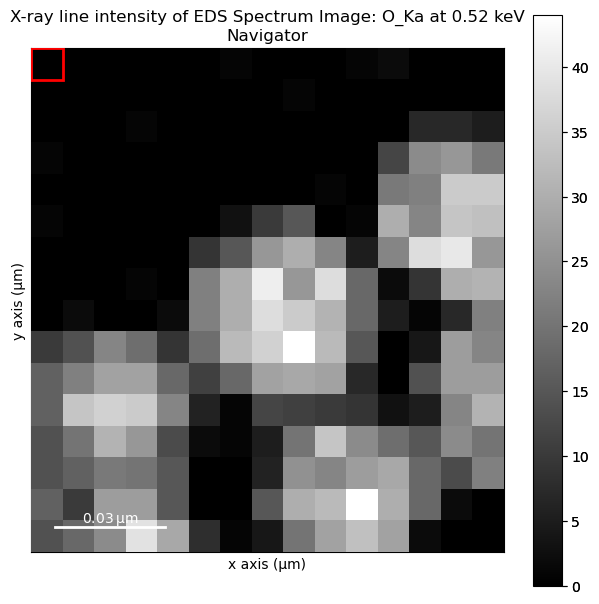

In [23]:
particles2.list[1].maps['O'].plot()

The composition of each particle can be accessed from the particle list using list[particle].composition.

In [24]:
particles2.list[1].composition

{'O': array([46.6682614]), 'Si': array([53.3317386])}

We can plot a radial profile of the particle intensity from both the image and our elemental maps.

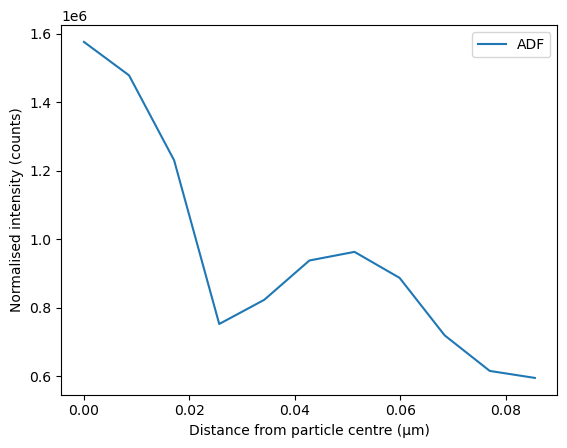

In [25]:
rp = ps.radial_profile(particles2.list[1],['Image'],plot=True)

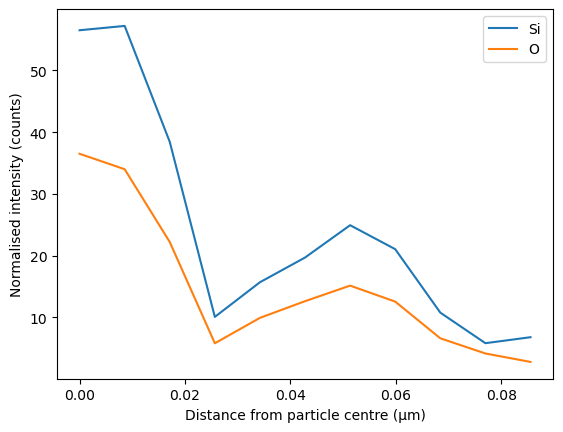

In [27]:
rp2 = ps.radial_profile(particles2.list[1],['Si','O'],plot=True)

## ParticleSpy with time-series data

ParticleSpy can also be used to track properties through a time-series of images. Let's see that in action on a short series of only 10 frames.

In [28]:
series = hs.load('particle_series.dm4')

In [29]:
%matplotlib qt

In [30]:
series.plot()

We'll define some new parameters that work well for this data.

In [31]:
params_series = ps.parameters()

In [32]:
params_series.generate(threshold='mean',min_size=200,gaussian=3)

For particle series, there is a modified ParticleAnalysis function called ParticleAnalysisSeries that deals with multiple frames.

In [33]:
particles_series = ps.particle_analysis_series(series, params_series)

In [35]:
particles_series.list[100].properties

{'area': {'value': 0.37706123399901337, 'units': 'nm^2'},
 'equivalent circular diameter': {'value': 0.6928847479301176, 'units': 'nm'},
 'x': {'value': 16.174399685484072, 'units': 'nm'},
 'y': {'value': 6.241437284091163, 'units': 'nm'},
 'major axis length': {'value': 1.0308994115209218, 'units': 'nm'},
 'minor axis length': {'value': 0.5138510562901347, 'units': 'nm'},
 'circularity': {'value': 0.6635403418626301, 'units': None},
 'eccentricity': {'value': 0.8669188704654908, 'units': None},
 'solidity': {'value': 0.8642857142857143, 'units': None},
 'intensity': {'value': 12842862.0, 'units': None},
 'intensity_max': {'value': 354781.34, 'units': None},
 'intensity_std': {'value': 0.007392826, 'units': None},
 'bbox_area': {'value': 0.6808915671800366, 'units': 'nm^2'},
 'bbox_length': {'value': 1.177587704896601, 'units': 'nm'},
 'frame': {'value': 3, 'units': None}}

Now we have a list of particles, with their properties attached including the frame number. We can now pass them through another function that uses the trackpy package to track the same particles through a time series.

In [36]:
series_test = ps.time_series_analysis(particles_series)

Frame 9: 25 trajectories present.


The returned series_test is a pandas dataframe, which is the standard object that is used in trackpy.

We can use trackpy to do cool things like plot the trajectory of all particles in the series. Note: while the axes say they are in pixels, they are actually in nm in this case! (I have just noticed this and will fix)

In [37]:
plt.figure()
tp.plot_traj(series_test)

<Axes: xlabel='x [px]', ylabel='y [px]'>

Trackpy also lets you correct for any systematic drift in the series.

In [38]:
drift = tp.compute_drift(series_test)
drift.plot()

<Axes: xlabel='frame'>

In [39]:
tm = tp.subtract_drift(series_test.copy(), drift)
plt.figure()
tp.plot_traj(tm)

<Axes: xlabel='x [px]', ylabel='y [px]'>

Using the particlespy workflow for time-series data, you also have any of the properties specified in the pandas dataframe and you can plot these as a function of frame number.

In [40]:
import matplotlib.pyplot as plt
plt.figure()
for index, particle in tm.groupby('particle'):
    plt.plot(particle['frame'], particle['area'], label=index)
    plt.xlabel('Frame')
    plt.ylabel('Area (nm)')